# Import Data

In [1]:
!wget -O input.txt "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"


--2024-09-19 10:33:22--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2024-09-19 10:33:22 (38.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [3]:
batch_size=64 #independent sequences process in parallel
block_size=256 #context length for predictions
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4

n_embed = 384 #Dimensions of Embedding vector
n_head = 6 #Number of (masked) multy head attention in each block
n_layer = 6 #Number of transformers layers
dropout = 0.2 #Dropout rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
with open ("input.txt" , 'r', encoding="utf-8") as f:
  text=f.read()

In [5]:
chars=sorted(list(set(text)))
vocab_size=len(chars)

# Define Encoder and Decoder

In [6]:
stoi={ch:i for i,ch in enumerate(chars)} #string to int
itos={i:ch for i,ch in enumerate(chars)} #int to string
encode = lambda s:[stoi[c] for c in s] #take a string and return a list of int
decode = lambda s:"".join([itos[c] for c in s]) #take a list of int and return a str

# Data Encoding and Data Split

In [7]:
data=torch.tensor(encode(text),dtype=torch.long)
n=int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

# Data Loading

In [8]:
def get_batch(split):
  data=train_data if split=="train" else val_data
  ix =torch.randint(len(data)-block_size,(batch_size,)) #we can not go over block_size
  x=torch.stack([data[i:i+block_size] for i in ix])
  y=torch.stack([data[i+1:i+block_size+1] for i in ix])
  x,y=x.to(device), y.to(device)
  return x,y
# get_batch("train")

In [9]:
@torch.no_grad()
def estimate_loss(eval_iters):
  out={}
  model.eval()
  for split in ["train","val"]:
    losses=torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y=get_batch(split)
      logits,loss=model(X,Y)
      losses[k]=loss.item()
    out[split]=losses.mean()
  model.train()
  return out

# Transformers Architecture


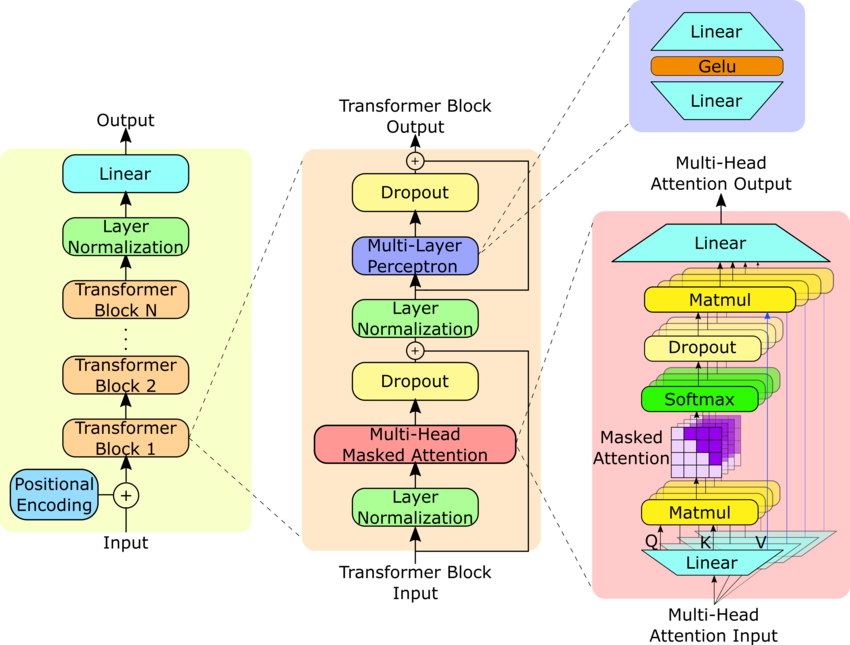

In [10]:
class Head(nn.Module):
  def __init__(self,head_size):
    super().__init__()
    self.key=nn.Linear(n_embed,head_size,bias=False)
    self.query=nn.Linear(n_embed,head_size,bias=False)
    self.value=nn.Linear(n_embed,head_size,bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout=nn.Dropout(dropout)
  def forward(self,x):
    B,T,C=x.shape
    k=self.key(x)
    q=self.query(x)
    wei=q@k.transpose(-2,-1)*k.shape[-1]**-0.5
    wei=wei.masked_fill(self.tril[:T,:T]==0,float("-inf"))
    wei=F.softmax(wei,dim=-1)
    wei=self.dropout(wei)
    v=self.value(x)
    out=wei@v
    return out



class MultiHeadAttention(nn.Module):
  def __init__(self,num_heads,head_size):
    super().__init__()
    self.heads=nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj=nn.Linear(head_size*num_heads,n_embed)
    self.dropout=nn.Dropout(dropout)
  def forward(self,x):
    out=torch.cat([h(x) for h in self.heads], dim=-1)
    out=self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.net=nn.Sequential(
    nn.Linear(n_embed,4*n_embed),
    nn.ReLU(),
    nn.Linear(4*n_embed,n_embed),
    nn.Dropout(dropout),
    )
  def forward(self,x):
    return self.net(x)


class Block(nn.Module):
  def __init__(self,n_embed,n_head):
    super().__init__()
    head_size=n_embed//n_head
    self.sa=MultiHeadAttention(n_head,head_size)
    self.ffwd=FeedForward(n_embed)
    self.ln1=nn.LayerNorm(n_embed)
    self.ln2=nn.LayerNorm(n_embed)

  def forward(self,x):
    x=x+self.sa(self.ln1(x))
    x=x+self.ffwd(self.ln2(x))
    return x


In [11]:
class GPTLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table=nn.Embedding(vocab_size,n_embed) #for each char in data, attribute a n_embed vector for each str in vocab
    self.position_embedding_table=nn.Embedding(block_size,n_embed)
    self.blocks=nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
    self.normalization=nn.LayerNorm(n_embed)
    self.linear=nn.Linear(n_embed,vocab_size)


  def forward(self,idx,targets=None):
    #idx (x) and targets (y) are shapes (B,T),(Batch (number of sequences), Time (len of sequences), Channel (vocab_size))


    B,T=idx.shape
    tok_emb=self.token_embedding_table(idx)
    #Embedding table to define the position of every str in the sequences of len T
    pos_emb=self.position_embedding_table(torch.arange(T,device=device))
    x=tok_emb+pos_emb
    x=self.blocks(x)
    x=self.normalization(x)
    logits=self.linear(x)
    if targets is None:
      loss=None
    else:
      B,T,C=logits.shape
      logits_reshape=logits.view(B*T,C) #reshape (concatenate)
      targets=targets.view(B*T)
      loss=F.cross_entropy(logits_reshape,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      logits,loss=self.forward(idx)
      logits=logits[:,-1,:] #take the 2 last str of each sequences for every batches -> become (B,C)
      probs=F.softmax(logits,dim=-1) #get probabilites from logits
      idx_next=torch.multinomial(probs,num_samples=1) #take a list of probabilites and return the index of the prob in the list which as been peeked
      idx=torch.cat((idx,idx_next),dim=1) #concatenate the input (idx) and the predictions which as been made
    return idx

In [12]:
model=GPTLanguageModel()
model.to(device)

GPTLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine

In [13]:
print(sum(p.numel() for p in model.parameters())/1e6, "M Parameters")

10.788929 M Parameters


In [14]:
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)

# Model Training

In [ ]:
history={"train":[],"val":[]}
for iter in range(max_iters):
  if iter%eval_interval==0:
    losses=estimate_loss(100)
    history["train"].append(losses["train"])
    history["val"].append(losses["val"])

    print(f"Step {iter} - Train Loss : {losses['train']:.4f} Val Loss : {losses['val']:.4f}")
  xb,yb=get_batch("train")
  logits,loss=model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


Step 0 - Train Loss : 4.3126 Val Loss : 4.3115


In [ ]:
plt.plot([i*100 for i in range(len(history["train"]))], history["train"],label="Train Loss")
plt.plot([i*100 for i in range(len(history["val"]))], history["val"],label="Validation Loss")
plt.legend()
plt.show()

# Model testing

In [ ]:
context=torch.zeros((1,1),dtype=torch.long,device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))